# Teste do modelo com dados de 2019

In [1]:
# import libraries
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import os
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
from joblib import dump
from keras import regularizers
from keras.models import Model, Sequential, load_model, model_from_json
from tensorflow.keras import layers
import tensorflow as tf
from sklearn import preprocessing
import matplotlib
from keras.callbacks import EarlyStopping

from keras.layers import Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.layers.convolutional import MaxPooling1D, Conv1D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
from sklearn.ensemble import RandomForestRegressor
import eli5
from eli5.sklearn import PermutationImportance
from xgboost import XGBRegressor

In [2]:
# Checando a memória da GPU
!nvidia-smi

Wed Sep 09 10:56:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 452.06       Driver Version: 452.06       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 207... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   58C    P8    15W /  N/A |    263MiB /  8192MiB |     11%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [19]:
# Parar recuso da memória da GPU
pid = 21804

In [ ]:
os.kill(pid,pid)

In [3]:
df = pd.read_excel('Data2019.xlsx')
df1=df

In [4]:
df.index = pd.to_datetime(df['Data'], format='%Y.%m.%d.%H.%M.%S')
df = df.drop('Data',1)
df = df.abs()

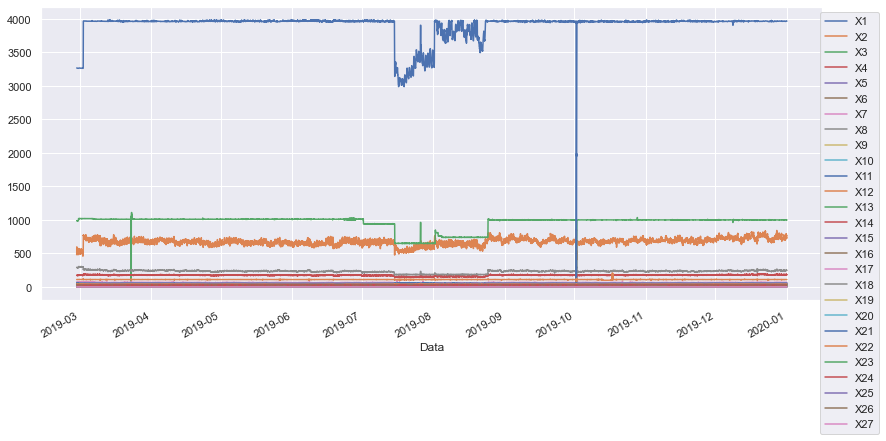

In [5]:
df.plot(figsize = (14,6))
plt.legend(loc='upper right', bbox_to_anchor=(0.58, 0.5, 0.5, 0.5))

In [6]:
train = df['2019-08-25 00:00:00':'2019-09-20 18:30:00'] # Período onde o compressor operou sem problemas
test =  df['2019-09-20 18:30:00':'2019-10-01 18:30:00'] # Período antes da falha

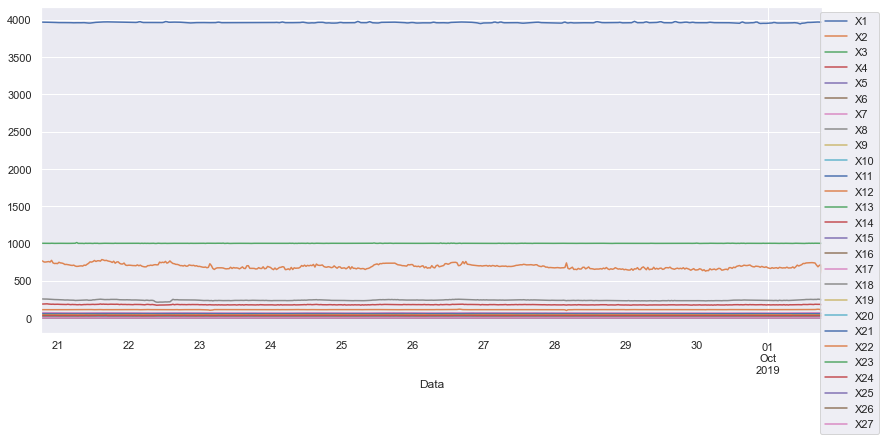

In [7]:
test.plot(figsize = (14,6))
plt.legend(loc='upper right', bbox_to_anchor=(0.58, 0.5, 0.5, 0.5))

In [8]:
# normalize the data
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
dump(scaler, scaler_filename)

['scaler_data']

In [9]:
# Conversão para float32 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [10]:
# reshape inputs for CNN 
X_train_cnn = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
print("Training data shape:", X_train_cnn.shape)
X_test_cnn = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print("Test data shape:", X_test_cnn.shape)

Training data shape: (1286, 27, 1)
Test data shape: (529, 27, 1)


In [11]:
# Preparar para teste
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(train), 
                              columns=train.columns, 
                              index=train.index)
# Utilizado Random shuffle nos dados de treinamento para selecionar de forma aleatória
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(test), 
                             columns=test.columns, 
                             index=test.index)

In [12]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('Anomaly_model.h5')

(0.0, 0.2)

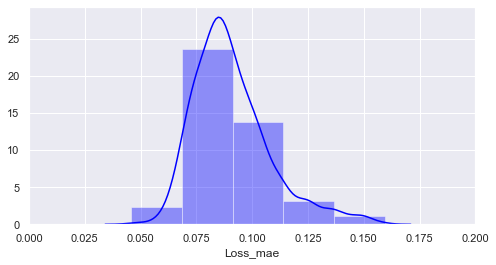

In [13]:
X_pred = model.predict(np.array(X_train_cnn))
X_pred = pd.DataFrame(X_pred, columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure(figsize = (8,4))
sns.distplot(scored['Loss_mae'],
             bins = 5, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.2])

In [14]:
X_pred = model.predict(np.array(X_test_cnn))
X_pred = pd.DataFrame(X_pred, columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] =  0.106
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
Data,,,
2019-09-20 18:30:00,0.133056,0.106,True
2019-09-20 19:00:00,0.124308,0.106,True
2019-09-20 19:30:00,0.122730,0.106,True
2019-09-20 20:00:00,0.124856,0.106,True
2019-09-20 20:30:00,0.133294,0.106,True


In [15]:
X_pred_train = model.predict(np.array(X_train_cnn))
X_pred_train = pd.DataFrame(X_pred_train, columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] =  0.106
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

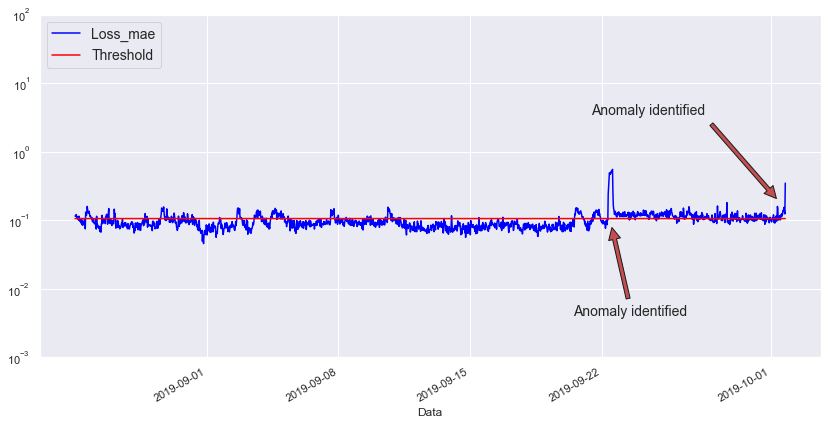

In [16]:
ax = scored.plot(logy=True,  figsize = (14,7), ylim = [1e-3,1e2],  color = ['blue','red'])
ax.annotate('Anomaly identified',fontsize = 14, xy=('2019-09-22 12:00:00', 0.09), xytext=('2019-09-20 11:00:00', 0.004),
            arrowprops=dict(facecolor='black', shrink=0.05, color = 'r', ec ='k'))

ax.annotate('Anomaly identified',fontsize = 14, xy=('2019-10-01 12:00:00', 0.18), xytext=('2019-09-21 11:00:00', 3.5),
            arrowprops=dict(facecolor='black', shrink=0.05, color = 'r',ec ='k'))

            
plt.legend(loc='upper left', fontsize = 14)

In [ ]:
# Concatenado os dados de treino e teste para comparar com a função gerada pelo modelo
df_TraTes = pd.concat([train,test])
# Realizando o Subset do resultado 
df0 = pd.DataFrame(scored.Loss_mae)

In [ ]:
# Agrupando o resultado dos Scores
df_fim = pd.merge(df_TraTes,df0, on=["Data"])
df_fim = df_fim.dropna()

In [ ]:
y = df_fim.iloc[:,-1]
X = df_fim.iloc[:,0:27]

In [ ]:
# visualisations
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(30, 25)})

In [ ]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [ ]:
np.random.seed(seed = 42)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
rf = RandomForestRegressor(n_estimators = 150,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

In [ ]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_valid, y_valid)))

In [ ]:
base_imp = imp_df(X_train.columns, rf.feature_importances_)
#base_imp

In [ ]:
plt.rcParams['figure.figsize'] = [11, 10]
var_imp_plot(base_imp, "Feature importance by - Tag's")